<a href="https://colab.research.google.com/github/lukipuki0/GWO/blob/main/GWO_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.special import gamma
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score, f1_score, roc_curve

# Librerias para CNN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import datetime
import time
import os
from google.colab import drive


link github: https://github.com/lukipuki0/GWO

In [2]:
drive.mount('/content/drive')

def crear_carpeta_ejecucion(base_path):
    # Obtener el timestamp actual
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    # Crear el nombre de la carpeta con base en el timestamp
    execution_folder = os.path.join(base_path, f'Ejecucion_GWO_{timestamp}')
    # Crear la carpeta
    os.makedirs(execution_folder, exist_ok=True)
    return execution_folder

Mounted at /content/drive


In [3]:
#************************************************************************************************************
#*********************************** FUNCION PARA CNN *******************************************************
def train_cnn_model(num_conv_layers, base_filter_value, use_batch_norm, lr, batch_size, epochs):
    start_time = time.time()  # inicio tiempo
    now = datetime.datetime.now()
    formatted_date = now.strftime('%Y%m%d_%H%M%S')

    # Directorio donde se guardarán las ejecuciones de CNN
    base_directory = '/content/drive/MyDrive/Colab Notebooks/Esquema1'
    folder_name = os.path.join(base_directory, f'ejecucion_cnn_{formatted_date}')

    # Revisar existencia de directorio
    os.makedirs(folder_name, exist_ok=True)
    log_file_path = os.path.join(folder_name, 'training_log.txt')

    # Ruta donde se guardará el mejor modelo
    model_save_path = os.path.join(folder_name, 'best_model.pth')

    class CustomCNN(nn.Module):
        def __init__(self, num_conv_layers, base_filter_value, use_batch_norm):
            super(CustomCNN, self).__init__()
            layers = []
            in_channels = 3  # Assuming input images have 3 channels (RGB)
            current_filters = base_filter_value

            for i in range(num_conv_layers):
                layers.append(nn.Conv2d(in_channels, current_filters, kernel_size=3, padding=1))
                if use_batch_norm:
                    layers.append(nn.BatchNorm2d(current_filters))
                layers.append(nn.ReLU(inplace=True))
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                in_channels = current_filters
                current_filters *= 2  # Double the number of filters for the next layer

            self.features = nn.Sequential(*layers)
            self.fc1 = nn.Linear(in_channels * (64 // 2**num_conv_layers)**2, 1024)
            self.dropout = nn.Dropout(0.5)
            self.fc2 = nn.Linear(1024, 2)

        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return F.log_softmax(x, dim=1)

    # Data loading and transformation
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
      #Ruta de acceso local en colab
    train_path = '/content/drive/MyDrive/Colab Notebooks/dataset_experimental/train'
    valid_path ='/content/drive/MyDrive/Colab Notebooks/dataset_experimental/valid'
    test_path = '/content/drive/MyDrive/Colab Notebooks/dataset_experimental/test'

    #Ruta de acceso en HPC
    #train_path = '../../Datasets/dataset_experimental/train'
    #valid_path = '../../Datasets/dataset_experimental/valid'
    #test_path = '../../Datasets/dataset_experimental/test'

    train_data = datasets.ImageFolder(train_path, transform=transform)
    valid_data = datasets.ImageFolder(valid_path, transform=transform)
    test_data = datasets.ImageFolder(test_path, transform=transform)

    train_loader = DataLoader(train_data, batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size, shuffle=False)

    model = CustomCNN(num_conv_layers, base_filter_value, use_batch_norm)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    train_loss_history, valid_loss_history, valid_accuracy_history = [], [], []
    y_true_all, y_pred_all = [], []

    best_valid_accuracy = 0  # Para rastrear la mejor precisión de validación
    with open(log_file_path, 'w') as log_file:
        log_file.write("Training Log\n")
        log_file.write("=============\n")
        print('\nResultados por epochs')
        for epoch in range(epochs):
            model.train()
            total_train_loss = 0
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item() * data.size(0)

            average_train_loss = total_train_loss / len(train_loader.dataset)
            train_loss_history.append(average_train_loss)

            model.eval()
            total_valid_loss, valid_correct, total_valid_samples = 0, 0, 0
            y_true_epoch, y_pred_epoch = [], []
            with torch.no_grad():
                for data, target in valid_loader:
                    output = model(data)
                    loss = criterion(output, target)
                    total_valid_loss += loss.item() * data.size(0)
                    pred = output.argmax(dim=1, keepdim=True)
                    valid_correct += pred.eq(target.view_as(pred)).sum().item()
                    total_valid_samples += data.size(0)
                    y_true_epoch.extend(target.cpu().numpy())
                    y_pred_epoch.extend(pred.cpu().numpy())

            average_valid_loss = total_valid_loss / total_valid_samples
            valid_accuracy = 100. * valid_correct / total_valid_samples
            valid_loss_history.append(average_valid_loss)
            valid_accuracy_history.append(valid_accuracy)
            y_true_all.extend(y_true_epoch)
            y_pred_all.extend(y_pred_epoch)

            # Guardar el mejor modelo
            if valid_accuracy > best_valid_accuracy:
                best_valid_accuracy = valid_accuracy
                torch.save(model.state_dict(), model_save_path)  # Guardar el modelo

            # Escribir los resultados de la época actual en el archivo
            epoch_msg = (f'Epoch {epoch+1}/{epochs}, Training Loss: {average_train_loss:.4f}, Validation Loss: {average_valid_loss:.4f}, '
                        f'Validation Accuracy: {valid_accuracy:.2f}%\n')
            log_file.write(epoch_msg)
            print(epoch_msg)

        # Resultados finales
        final_average_valid_loss = sum(valid_loss_history) / len(valid_loss_history)
        final_average_valid_accuracy = sum(valid_accuracy_history) / len(valid_accuracy_history)

        y_true_all = np.array(y_true_all)
        y_pred_all = np.array(y_pred_all)

        conf_matrix = confusion_matrix(y_true_all, y_pred_all)
        recall = recall_score(y_true_all, y_pred_all, average='macro')
        auc_score = roc_auc_score(y_true_all, y_pred_all)
        f1 = f1_score(y_true_all, y_pred_all, average='macro')

        tn, fp, fn, tp = conf_matrix.ravel()
        specificity = tn / (tn + fp)

        end_time = time.time()
        total_execution_time = end_time - start_time

        hours, rem = divmod(total_execution_time, 3600)
        minutes, seconds = divmod(rem, 60)
        time_formatted = f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

        # Escribir los resultados finales en el archivo
        final_msg = (f'\nFinal Results\n'
                     f'Final Average Validation Loss: {final_average_valid_loss:.4f}\n'
                     f'Final Average Validation Accuracy: {final_average_valid_accuracy:.2f}%\n'
                     f'Recall: {recall:.4f}, Specificity: {specificity:.4f}, F1 Score: {f1:.4f}, AUC: {auc_score:.4f}\n'
                     f'Total Execution Time: {time_formatted} (hh:mm:ss)\n')
        log_file.write(final_msg)

        # Escribir la matriz de confusión en el archivo
        conf_matrix_msg = (f'\nConfusion Matrix:\n{conf_matrix}\n')
        log_file.write(conf_matrix_msg)
        print(final_msg)
        print(conf_matrix_msg)

    # Guardar gráficos
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.xlabel('Prediction')
    plt.ylabel('Real')
    plt.savefig(os.path.join(folder_name, 'confusion_matrix.png'))
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(valid_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'loss_plot.png'))
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.plot(valid_accuracy_history, label='Validation Accuracy')
    plt.title('Validation Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'accuracy_plot.png'))
    plt.close()

    metrics_values = {'Recall': recall, 'Specificity': specificity, 'F1 Score': f1, 'AUC': auc_score}
    metric_names = list(metrics_values.keys())
    metric_values = list(metrics_values.values())

    plt.figure(figsize=(10, 5))
    bars = plt.bar(metric_names, metric_values, color=['orange', 'cyan', 'magenta', 'brown'])
    plt.title('Final Metrics: Recall, Specificity, F1 Score, AUC')
    plt.ylabel('Valor')
    plt.ylim(0, 1)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10, color='black')

    plt.savefig(os.path.join(folder_name, 'metrics_bar_plot.png'), bbox_inches='tight')
    plt.close()

    return final_average_valid_loss, final_average_valid_accuracy, recall, specificity, f1, auc_score, total_execution_time, model


In [13]:
#************************************************************************************************************
#**********************************  G R E Y   W O L F   O P T I M A Z E R  *********************************

# Grey Wolf Optimizer (GWO)
def ejecutarGWO(wolves, max_iter, w1, w2, w3):

    #guardar el mejor valor durante la ejecucion
    best_wolf = None
    best_value = float('inf')
    best_accuracy = 0
    best_loss = 0
    best_time = 0
    best_f1=0
    best_recall=0
    best_specificity=0
    best_auc=0
    best_trained_model=None

    #Historial de datos por iteracion
    best_accuracy_per_iteration = []
    best_loss_per_iteration = []
    best_execution_time_per_iteration = []
    best_wolf_per_iteration=[]
    fitness_scores = []
    best_recall_per_iteration = []
    best_specificity_per_iteration = []
    best_f1_per_iteration = []
    best_auc_per_iteration = []

    # Definir la carpeta base donde se crearán las subcarpetas de cada ejecución
    base_path = '/content/drive/MyDrive/Colab Notebooks/HistoryGWO'

    # Crear una carpeta para esta ejecución dentro de HistoryGWO
    execution_folder = crear_carpeta_ejecucion(base_path)

    # Definir rutas para guardar datos
    best_model_save_path = os.path.join(execution_folder, 'best_model.pth')
    history_file_path = os.path.join(execution_folder, 'History_GWO.txt')

    #best_model_save_path = '/content/drive/MyDrive/Colab Notebooks/HistoryGWO/best_model.pth'
    #history_file_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/HistoryGWO', 'History_GWO.txt')
    #Ruta para HPC
    #history_file_path = os.path.join('Esquema1/Historial', 'history.txt')


    with open(history_file_path, 'w') as f:
        f.write("*************************")
        f.write("\nParametros de la ejecucion")
        f.write(f"\nNumero de lobos: {nwolves}")
        f.write(f"\nNumero de iteraciones: {max_iter}")
        f.write("\n*************************")
        f.write("")

    #calcular antes de los movimientos y actualizar lobos
    for wolf in wolves:

        print("\nLobo actual", wolf)

        final_average_valid_loss, final_average_valid_accuracy, recall, specificity, f1, auc_score, total_execution_time,trained_model = train_cnn_model(
            num_conv_layers=wolf['num_layers'],
            base_filter_value=wolf['num_filters'],
            use_batch_norm=wolf['batch_norm'],
            lr=wolf['lr'],
            batch_size=wolf['batch_size'],
            epochs=wolf['epochs']
        )

        fitness_scores.append(final_average_valid_accuracy)

        print("\nAverage accuracy", final_average_valid_accuracy)
        print("\nAverage Loss", final_average_valid_loss)
        print("\nTiempo total en segundos ", total_execution_time)

        # Guardar el mejor valor
        if best_accuracy < final_average_valid_accuracy:
            best_accuracy = final_average_valid_accuracy
            best_loss = final_average_valid_loss
            best_time = total_execution_time
            best_wolf = wolf
            best_f1=f1
            best_recall=recall
            best_specificity=specificity
            best_auc=auc_score
            best_trained_model=trained_model

    #guardar en archivo
    #with open(history_file_path, 'a') as f:
        #guardar el mejor lobo
       # f.write(f'{best_wolf}\n')
       # f.write(f'{best_accuracy},{best_loss},{best_time}\n')

    print("********************************************************************************************************************")
    print("*********************************** SE COMIENZAN A ACTUALIZAR PARAMETROS CNN ***************************************")
    print("********************************************************************************************************************")
    print()

    for t in range(max_iter):
        print("********************************************************************************************************************")
        print("************************************************  ITERACION ", t+1, " **********************************************")
        print("********************************************************************************************************************")
        print()
        best_wolf_iteration = None
        best_value_iteration = float('inf')
        best_accuracy_iteration = 0
        best_loss_iteration = 0
        best_time_iteration = 0
        best_f1_iteration = 0
        best_recall_iteration = 0
        best_specificity_iteration = 0
        best_auc_iteration = 0

        a = 2 - t * ((2) / max_iter)  # Disminución de a linealmente de 2 a 0

        # Ordenar lobos según fitness
        sorted_wolves = sorted(zip(fitness_scores, wolves), key=lambda x: x[0])
        alpha, beta, delta = sorted_wolves[0][1], sorted_wolves[1][1], sorted_wolves[2][1]

        # Actualizar posiciones de los lobos restantes
        for i, wolf in enumerate(wolves):
            for param in wolf:

                # Ignorar la actualización de Batch Norm (parámetro discreto)
                if param == 'batch_norm':
                    continue  # No actualizar el parámetro batch_norm (discreto)

                if isinstance(wolf[param], (int, float)):
                    r1, r2 = random.random(), random.random()
                    A1 = 2 * a * r1 - a
                    C1 = 2 * r2
                    D_alpha = abs(C1 * alpha[param] - wolf[param])
                    X1 = alpha[param] - A1 * D_alpha

                    r1, r2 = random.random(), random.random()
                    A2 = 2 * a * r1 - a
                    C2 = 2 * r2
                    D_beta = abs(C2 * beta[param] - wolf[param])
                    X2 = beta[param] - A2 * D_beta

                    r1, r2 = random.random(), random.random()
                    A3 = 2 * a * r1 - a
                    C3 = 2 * r2
                    D_delta = abs(C3 * delta[param] - wolf[param])
                    X3 = delta[param] - A3 * D_delta

                    # Actualización de la posición
                    wolf[param] = (X1 + X2 + X3) / 3

                    # Truncar o redondear los parámetros que deben ser enteros
                    if param in ['num_layers', 'num_filters', 'batch_size', 'epochs']:
                        wolf[param] = int(round(wolf[param]))  # Convertir a entero redondeando
                        #que ningun parametro sea menor a 1
                        if wolf[param] < 1:
                            wolf[param] = 1
                    # Asegurar que el valor de lr esté en el rango permitido
                    if param == 'lr':
                        wolf[param] = max(0.0001, min(wolf[param], 0.01))  # Mantener lr dentro de [0.0001, 0.01]


        #calcular fitnees despues de actualizar lobos
        k = 0
        for wolf in wolves:
            print("*************************************************************************************************************")
            print("************************************************  LOBO ",k+1,"*************************************************")
            print("*************************************************************************************************************")
            print("\nLobo actual", wolf)
            k = k+1
            final_average_valid_loss, final_average_valid_accuracy, recall, specificity, f1, auc_score, total_execution_time,trained_model = train_cnn_model(
                num_conv_layers=wolf['num_layers'],
                base_filter_value=wolf['num_filters'],
                use_batch_norm=wolf['batch_norm'],
                lr=wolf['lr'],
                batch_size=wolf['batch_size'],
                epochs=wolf['epochs']
            )
            fitness_scores.append(final_average_valid_accuracy)

            print("\nAverage accuracy", final_average_valid_accuracy)
            print("\nAverage Loss", final_average_valid_loss)
            print("\nTiempo total en segundos ", total_execution_time)

            if final_average_valid_accuracy > best_accuracy_iteration:
                best_accuracy_iteration = final_average_valid_accuracy
                best_loss_iteration = final_average_valid_loss
                best_time_iteration = total_execution_time
                best_wolf_iteration = wolf
                best_f1_iteration=f1
                best_recall_iteration=recall
                best_specificity_iteration=specificity
                best_auc_iteration=auc_score
                best_trained_model=trained_model
            # actualizar el mejor valor
            if final_average_valid_accuracy > best_accuracy:

                best_accuracy = final_average_valid_accuracy
                best_loss = final_average_valid_loss
                best_time = total_execution_time
                best_wolf = wolf
                best_f1=f1
                best_recall=recall
                best_specificity=specificity
                best_auc=auc_score
                best_trained_model=trained_model

        # Guardar historial
        print("SE GUARDA ITERACION")
        with open(history_file_path, 'a') as f:
            f.write(f"\nIteration {t + 1}:\n")
            f.write(f"Best wolf: {best_wolf_iteration}\n")
            f.write(f"Best Average Accuracy: {best_accuracy_iteration:.2f}%\n")
            f.write(f"Best Average Loss: {best_loss_iteration:.4f}\n")
            f.write(f"Best Recall: {best_recall_iteration:.4f}\n")
            f.write(f"Best Specificity: {best_specificity_iteration:.4f}\n")
            f.write(f"Best F1 Score: {best_f1_iteration:.4f}\n")
            f.write(f"Best AUC: {best_auc_iteration:.4f}\n")
            f.write(f"Best Execution Time: {best_time_iteration:.2f} seconds\n")
            f.write("\n")

        best_accuracy_per_iteration.append(best_accuracy)
        best_loss_per_iteration.append(best_loss)
        best_execution_time_per_iteration.append(best_time)
        best_recall_per_iteration.append(recall)
        best_specificity_per_iteration.append(specificity)
        best_f1_per_iteration.append(f1)
        best_auc_per_iteration.append(auc_score)
    #guardar el mejor de todos
    with open(history_file_path, 'a') as f:
        f.write("******************\n")
        f.write(f"Mejor solucion\n")
        f.write("******************\n")
        f.write(f"Best wolf: {best_wolf_iteration}\n")
        f.write(f"Best Average Accuracy: {best_accuracy_iteration:.2f}%\n")
        f.write(f"Best Average Loss: {best_loss_iteration:.4f}\n")
        f.write(f"Best Recall: {best_recall_iteration:.4f}\n")
        f.write(f"Best Specificity: {best_specificity_iteration:.4f}\n")
        f.write(f"Best F1 Score: {best_f1_iteration:.4f}\n")
        f.write(f"Best AUC: {best_auc_iteration:.4f}\n")
        f.write(f"Best Execution Time: {best_time_iteration:.2f} seconds\n")
        f.write("\n")

  # Guardar el mejor modelo en la carpeta raíz
    torch.save(best_trained_model.state_dict(), best_model_save_path)
    print(f"El mejor modelo de todas las iteraciones ha sido guardado en: {best_model_save_path}")


    # Check if all metric lists have the correct length before plotting
    if len(best_recall_per_iteration) == maxIter:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, maxIter + 1), best_recall_per_iteration, marker='o', linestyle='-', color='orange')
        plt.title('Evolución del Recall por Iteración')
        plt.xlabel('Iteración')
        plt.ylabel('Recall')
        plt.grid(True)
        plt.savefig(os.path.join(execution_folder, 'evolucion_recall_por_iteracion.png'))
        plt.close()

    # Repeat similar checks for other metrics
    if len(best_specificity_per_iteration) == maxIter:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, maxIter + 1), best_specificity_per_iteration, marker='o', linestyle='-', color='cyan')
        plt.title('Evolución de Specificity por Iteración')
        plt.xlabel('Iteración')
        plt.ylabel('Specificity')
        plt.grid(True)
        plt.savefig(os.path.join(execution_folder, 'evolucion_specificity_por_iteracion.png'))
        plt.close()

    if len(best_f1_per_iteration) == maxIter:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, maxIter + 1), best_f1_per_iteration, marker='o', linestyle='-', color='magenta')
        plt.title('Evolución del F1 Score por Iteración')
        plt.xlabel('Iteración')
        plt.ylabel('F1 Score')
        plt.grid(True)
        plt.savefig(os.path.join(execution_folder, 'evolucion_f1_score_por_iteracion.png'))
        plt.close()

    if len(best_auc_per_iteration) == maxIter:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, maxIter + 1), best_auc_per_iteration, marker='o', linestyle='-', color='brown')
        plt.title('Evolución del AUC por Iteración')
        plt.xlabel('Iteración')
        plt.ylabel('AUC')
        plt.grid(True)
        plt.savefig(os.path.join(execution_folder, 'evolucion_auc_por_iteracion.png'))
        plt.close()
    with open(history_file_path, 'a') as f:
        f.write("Ejeucion terminada")
    return best_wolf, best_value, best_accuracy, best_loss, best_time, best_wolf_per_iteration,best_accuracy_per_iteration, best_loss_per_iteration, best_execution_time_per_iteration

# Inicializar población de lobos (soluciones aleatorias)
def initialize_population(param_ranges):
    wolf = {}
    for param, options in param_ranges.items():
        if isinstance(options, list):  # Si las opciones son una lista
            wolf[param] = random.choice(options)  # Selecciona un valor aleatorio de la lista
        elif isinstance(options, tuple):  # Para rangos num�ricos, como 'lr' y epochs
            wolf[param] = round(random.uniform(options[0], options[1]), 4)  # Genera un valor flotante aleatorio para lr, redondeado en 4 decimales
            if param == "epochs":
                wolf[param] = int(wolf[param])  # Asegurar que epochs sea un entero
    return wolf

In [12]:
# Definición de los hiperparámetros con sus rangos
# *****Rangos de los hiperparametros de CNN*******
param_ranges = {
    "num_layers": [2, 3, 4, 5],
    "num_filters": [2, 4, 6, 8, 10],
    "batch_norm": ["true", "false"],
    "epochs": (2, 5),
    "batch_size": [16, 32, 64],
    "lr": (0.0001, 0.01)
}
# Parámetros de la ejecución
nwolves = 4     # Tamaño de la población (lobos)
maxIter = 2      # Número de iteraciones
w1 = 0.85
w2 = 0.1
w3 = 0.05
# Inicialización de la población de lobos
wolves = [initialize_population(param_ranges) for _ in range(nwolves)]

print("poblacion de lobos")
for wolf in wolves:
    print(wolf)


# Ejecucion del algoritmo GWO
start_time_gwo = time.time()
best_wolf, best_value, best_accuracy, best_loss, best_time, best_wolf_per_iteration,best_accuracy_per_iteration, best_loss_per_iteration, best_execution_time_per_iteration = ejecutarGWO(wolves,maxIter, w1, w2, w3)
end_time_gwo = time.time()
print("*****************************************************************************************")
print("**********************************  Resultados finales  *********************************")
print("*****************************************************************************************")
print("\nTiempo de ejejucion total ", end_time_gwo - start_time_gwo)
# Motrar los hiperparámetros óptimos obtenidos
print("\nMejor lobo", best_wolf)
print("\nAverage accuracy", best_accuracy)
print("\nAverage Loss", best_loss)
print("\nTiempo total en segundos ", best_time)

poblacion de lobos
{'num_layers': 5, 'num_filters': 4, 'batch_norm': 'false', 'epochs': 2, 'batch_size': 32, 'lr': 0.0087}
{'num_layers': 4, 'num_filters': 8, 'batch_norm': 'true', 'epochs': 2, 'batch_size': 64, 'lr': 0.0077}
{'num_layers': 3, 'num_filters': 8, 'batch_norm': 'false', 'epochs': 4, 'batch_size': 64, 'lr': 0.0015}
{'num_layers': 3, 'num_filters': 4, 'batch_norm': 'false', 'epochs': 3, 'batch_size': 32, 'lr': 0.0015}

Lobo actual {'num_layers': 5, 'num_filters': 4, 'batch_norm': 'false', 'epochs': 2, 'batch_size': 32, 'lr': 0.0087}

Resultados por epochs
Epoch 1/2, Training Loss: 3.4548, Validation Loss: 0.7046, Validation Accuracy: 50.00%

Epoch 2/2, Training Loss: 1.1137, Validation Loss: 0.7692, Validation Accuracy: 50.00%


Final Results
Final Average Validation Loss: 0.7369
Final Average Validation Accuracy: 50.00%
Recall: 0.5000, Specificity: 0.5000, F1 Score: 0.5000, AUC: 0.5000
Total Execution Time: 00:00:08 (hh:mm:ss)


Confusion Matrix:
[[100 100]
 [100 100]]


A

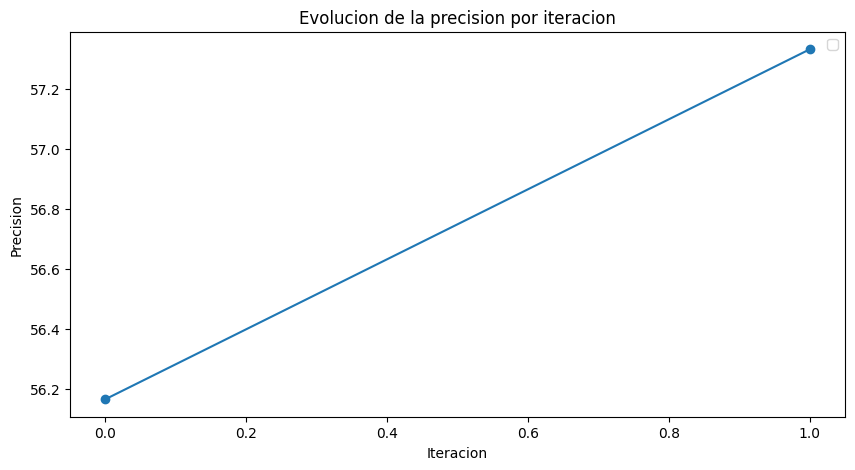

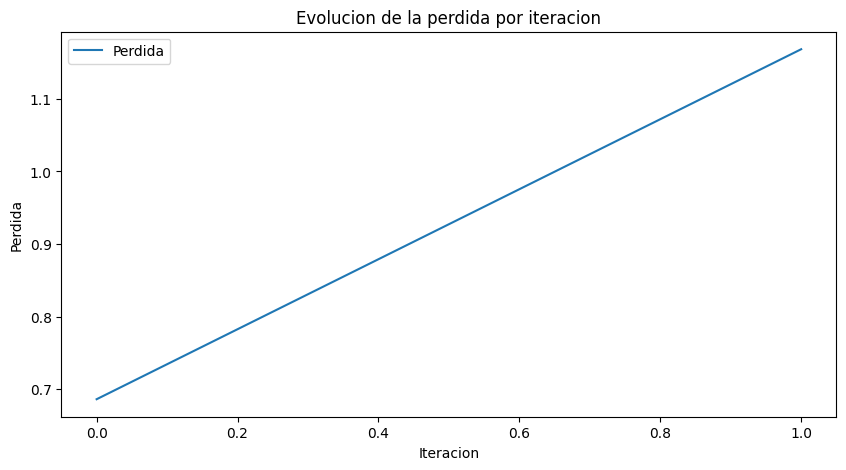

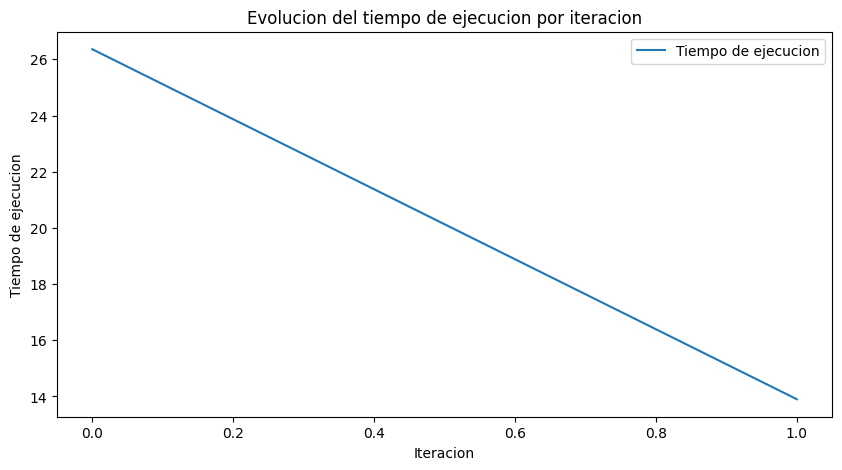

In [ ]:
#mostrar resultados por iteracion

#mostrar grafico de la evolucion de la precision
plt.figure(figsize=(10, 5))
plt.plot(best_accuracy_per_iteration, marker='o', linestyle='-')
plt.title('Evolucion de la precision por iteracion')
plt.xlabel('Iteracion')
plt.ylabel('Precision')
plt.legend()
plt.show()



#mostrar grafico de la evolucion de la perdida
plt.figure(figsize=(10, 5))
plt.plot(best_loss_per_iteration, label='Perdida')
plt.title('Evolucion de la perdida por iteracion')
plt.xlabel('Iteracion')
plt.ylabel('Perdida')
plt.legend()
plt.show()

#mostrar grafico de la evolucion del tiempo de ejecucion
plt.figure(figsize=(10, 5))
plt.plot(best_execution_time_per_iteration, label='Tiempo de ejecucion')
plt.title('Evolucion del tiempo de ejecucion por iteracion')
plt.xlabel('Iteracion')
plt.ylabel('Tiempo de ejecucion')
plt.legend()
plt.show()

In [ ]:
best_accuracy_per_iteration

[56.166666666666664, 57.333333333333336]